In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'


import networkx as nx
import copy

import json
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
import heapq
from collections import Counter

import jsbeautifier
opts = jsbeautifier.default_options()
opts.indent_size = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:

class Prob:
    def __init__(self, P, H, W, L, F, obstacle_ratio=0.1, total_allocation_ratio=0.8, min_demands=3, rnd_seed=42):
        self.P = P
        self.H = H
        self.W = W
        self.L = L
        self.F = F

        self.rnd_seed = rnd_seed

        np.random.seed(rnd_seed)

        self.obstacle_ratio = obstacle_ratio
        self.total_allocation_ratio = total_allocation_ratio
        self.min_demands = min_demands

        G_grid = self._create_multilayer_grid_graph(W, H, L, obstacle_ratio)

        self.N = len(G_grid.nodes)

        self.K = self._generate_random_demands(P, self.N - 1, total_allocation_ratio=total_allocation_ratio, min_demands=min_demands)

        

        E = [
            (G_grid.nodes[u]['id'], G_grid.nodes[v]['id'])
            for (u,v) in G_grid.edges()
        ]

        self.E = E

        prob_info = {
            'N': self.N,
            'E': E,
            'P': self.P,
            'K': self.K,
            'F': F,
            'LB': self._get_LB()
        }

        self.G_grid = G_grid
        self.prob_info = prob_info



    def _create_multilayer_grid_graph(self, W, H, L, obstacle_ratio=0.1):
        """
        Create a multilayer grid graph with H layers, W columns, and F features.
        Each node in the grid has F features.
        """

        G = nx.Graph()
        for l in range(L):
            for h in range(H):
                for w in range(W):
                    if h < H - 1:
                        G.add_edge((w, h, l), (w, h + 1, l))
                    if w < W - 1:
                        G.add_edge((w, h, l), (w + 1, h, l))

        for x,y,z in G.nodes:
            G.nodes[(x,y,z)]['pos'] = (x, y + z * (H * 1.2))
            G.nodes[(x,y,z)]['type'] = 'hold'

        # Ramps connecting layers
        for l in range(L):
            if l < L - 1:

                ramp_nodes = [(int(W/2), 0, l), (int(W/2), 0, l+1), (int(W/2), H-1, l), (int(W/2), H-1, l+1)]

                for n in ramp_nodes:
                    G.nodes[n]['type'] = 'ramp'

                G.add_edge((int(W/2), 0, l), (int(W/2), 0, l+1), ramp=True)
                G.add_edge((int(W/2), H-1, l), (int(W/2), H-1, l+1), ramp=True)


        gate_node = (0, 0, 0)

        G.nodes[gate_node]['type'] = 'gate'

        for x,y,z in G.nodes:
            if G.nodes[(x,y,z)]['type'] == 'hold':
                if obstacle_ratio > np.random.rand():
                    G.nodes[(x,y,z)]['type'] = 'obstacle'
                    G.remove_edges_from(list(G.edges((x,y,z))))

        nodes_by_distances = sorted([(l,n) for (n,l) in nx.shortest_path_length(G, source=(gate_node)).items()])

        for idx,(l,n) in enumerate(nodes_by_distances):
            G.nodes[n]['id'] = idx
            G.nodes[n]['distance'] = l

        # Remove nodes that are not reachable from the gate
        nodes_to_remove = []
        for n in G:
            if 'id' not in G.nodes[n]:
                nodes_to_remove.append(n)
        G.remove_nodes_from(nodes_to_remove)

        return G


    def _generate_random_demands(self, P, max_capa, total_allocation_ratio=0.8, min_demands=3):
        """
        Generate random demands for P ports with a maximum capacity of max_capa.
        """

        K = {

        }

        total_allocation_ratio = 0.8

        loading_demands = np.zeros(P, dtype=int)
        unloading_demands = np.zeros(P, dtype=int)

        allocations = np.zeros(P, dtype=int)

        net_increase_demands = np.zeros(P, dtype=int)

        while allocations.sum() < total_allocation_ratio * max_capa * P:
            # We put more weight on the early ports
            origin = np.random.choice(range(P-1), p=[((P-1-p)/sum(range(1,P))) for p in range(P-1)])
            destination = np.random.randint(origin+1, P)

            capa_slack = max_capa - allocations[origin:destination+1].max()

            if capa_slack > 0:

                demand_to_add = np.random.randint(1, max(min(min_demands, capa_slack), 2))

                loading_demands[origin] += demand_to_add
                unloading_demands[destination] += demand_to_add

                if (origin, destination) not in K:
                    K[(origin, destination)] = demand_to_add
                else:
                    K[(origin, destination)] += demand_to_add

                allocations[origin:destination+1] += demand_to_add

        K = sorted(K.items())

        return K
    

    def _get_LB(self):
        """
        Get the lower bound of the problem.
        """

        G = nx.Graph()

        G.add_edges_from(self.E)

        sl = nx.shortest_path_length(G, source=0)
        sorted_dists = sorted(sl.values())[1:]

        F = self.F

        LB = 0

        for p in range(self.P):
            total_load_demands = sum([dem for ((o,d), dem) in self.K if o == p])
            LB += F * total_load_demands + sum(sorted_dists[:total_load_demands])
            
            total_unload_demands = sum([dem for ((o,d), dem) in self.K if d == p])
            LB += F * total_unload_demands + sum(sorted_dists[:total_unload_demands])

        return LB
        

    def save_to_file(self, filename, with_graph=True):
        """
        Save the graph to a file.
        """

        prob_info = copy.deepcopy(self.prob_info)

        if with_graph:
            prob_info['grid_graph'] = {
                'nodes': list(self.G_grid.nodes(data=True)),
                'edges': list(self.G_grid.edges(data=True))
            }


        with open(filename, "w") as f:
            f.write(jsbeautifier.beautify(json.dumps(prob_info, default=convert_to_int), opts))


    def draw_graph(self):

        grid = self.G_grid
        W = self.W
        H = self.H
        L = self.L

        ramp_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'ramp']
        hold_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'hold']
        gate_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'gate']
        obstacle_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'obstacle']

        plt.figure(figsize=(W, H * L))

        node_size = 100

        nx.draw_networkx_nodes(grid, nodelist=ramp_nodes, pos=nx.get_node_attributes(grid, 'pos'), node_shape='s', node_color='blue', node_size=node_size)
        nx.draw_networkx_nodes(grid, nodelist=hold_nodes, pos=nx.get_node_attributes(grid, 'pos'), node_shape='o', node_color='green', node_size=node_size)
        nx.draw_networkx_nodes(grid, nodelist=gate_nodes, pos=nx.get_node_attributes(grid, 'pos'), node_shape='*', node_color='orange', node_size=node_size*3)


        ramp_edges = [(u, v) for (u, v, attr) in grid.edges(data=True) if 'ramp' in attr]
        common_edges = [(u, v) for (u, v, attr) in grid.edges(data=True) if 'ramp' not in attr]

        nx.draw_networkx_edges(grid, edgelist=common_edges, pos=nx.get_node_attributes(grid, 'pos'), alpha=0.5, edge_color='gray')
        nx.draw_networkx_edges(grid, edgelist=ramp_edges, pos=nx.get_node_attributes(grid, 'pos'), alpha=0.5, width=2, edge_color='gray', connectionstyle='arc3,rad=0.3', arrows=True, min_source_margin=0, min_target_margin=0, node_size=node_size)


        nx.draw_networkx_labels(grid, pos=nx.get_node_attributes(grid, 'pos'), labels=nx.get_node_attributes(grid, 'id'), font_size=6, font_color='white', verticalalignment='center', horizontalalignment='center')



def convert_to_int(obj):
    if isinstance(obj, np.int64):
        return int(obj)  
    raise TypeError(f"Type {type(obj)} not serializable")
  

[((0, 1), 14),
 ((0, 2), 2),
 ((0, 3), 1),
 ((0, 4), 1),
 ((2, 4), 18),
 ((3, 4), 2)]

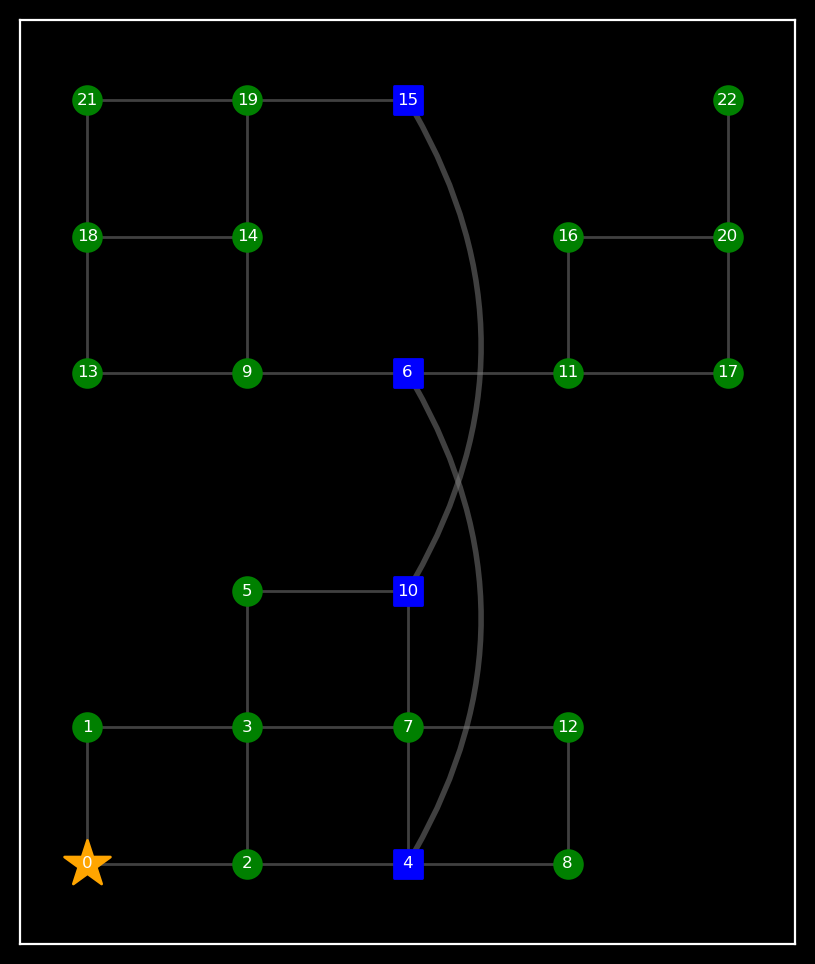

In [34]:
P, H, W, L, F = 5, 3, 5, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.25, total_allocation_ratio=1.0, min_demands=20, rnd_seed=3)


display(prob.prob_info['K'])
prob.draw_graph()

In [36]:
prob.prob_info['LB']

7863

In [ ]:


prob_info = prob.prob_info




G = nx.Graph()

G.add_edges_from(prob_info['E'])

sl = nx.shortest_path_length(G, source=0)
sorted_dists = sorted(sl.values())[1:]

F = prob_info['F']

LB = 0

for p in range(P):
    total_load_demands = sum([dem for ((o,d), dem) in prob.prob_info['K'] if o == p])
    LB += F * total_load_demands + sum(sorted_dists[:total_load_demands])
    
    total_unload_demands = sum([dem for ((o,d), dem) in prob.prob_info['K'] if d == p])
    LB += F * total_unload_demands + sum(sorted_dists[:total_unload_demands])




LB

7863

In [28]:
LB

7863

In [14]:
G = nx.Graph()

G.add_edges_from(prob.prob_info['E'])

sl = nx.shortest_path_length(G, source=0)

In [37]:
P, H, W, L, F = 5, 3, 5, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.9, min_demands=5, rnd_seed=2)
prob.save_to_file("exercise_problems/prob1.json", with_graph=True)

P, H, W, L, F = 5, 3, 10, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.9, min_demands=10, rnd_seed=8)
prob.save_to_file("exercise_problems/prob2.json", with_graph=True)

P, H, W, L, F = 10, 4, 10, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.3, total_allocation_ratio=0.9, min_demands=10, rnd_seed=4)
prob.save_to_file("exercise_problems/prob3.json", with_graph=True)

P, H, W, L, F = 10, 4, 15, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.3, total_allocation_ratio=0.9, min_demands=20, rnd_seed=2)
prob.save_to_file("exercise_problems/prob4.json", with_graph=True)

P, H, W, L, F = 10, 4, 15, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=1.0, min_demands=5, rnd_seed=4)
prob.save_to_file("exercise_problems/prob5.json", with_graph=True)

P, H, W, L, F = 10, 4, 15, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=1.0, min_demands=35, rnd_seed=4)
prob.save_to_file("exercise_problems/prob6.json", with_graph=True)

P, H, W, L, F = 10, 4, 15, 5, 200
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=1.0, min_demands=5, rnd_seed=4)
prob.save_to_file("exercise_problems/prob7.json", with_graph=True)

P, H, W, L, F = 10, 4, 15, 5, 200
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=1.0, min_demands=40, rnd_seed=2)
prob.save_to_file("exercise_problems/prob8.json", with_graph=True)

P, H, W, L, F = 10, 4, 15, 5, 200
prob = Prob(P, H, W, L, F, obstacle_ratio=0.25, total_allocation_ratio=1.0, min_demands=20, rnd_seed=3)
prob.save_to_file("exercise_problems/prob9.json", with_graph=True)

P, H, W, L, F = 15, 5, 20, 5, 400
prob = Prob(P, H, W, L, F, obstacle_ratio=0.25, total_allocation_ratio=1.0, min_demands=20, rnd_seed=3)
prob.save_to_file("exercise_problems/prob10.json", with_graph=True)